# Comparative Analysis of NLLB Fine-Tuning Methodologies
## Objective
The objective of this notebook is to serve as the final experimental and analysis hub for the thesis. It conducts the **Adapter-Based (LoRA) Fine-Tuning** experiment and then performs a comprehensive, multi-metric comparative analysis between the **Baseline**, the **Fully Fine-Tuned**, and the newly trained **LoRA-Tuned** models. The script's final outputs are the definitive tables and visualizations that compare the performance and efficiency of all three approaches.

## Methodology
The notebook follows a rigorous, multi-stage experimental design:

1. **Data Loading:** Loads the pre-split and tokenized datasets for training, validation, and testing.
2. **Baseline Evaluation:** Establishes a performance benchmark by evaluating the original, pre-trained NLLB model on the held-out test set.
3. **Adapter-Based (LoRA) Fine-Tuning:** Loads the base NLLB model in 8-bit precision, injects trainable LoRA adapters, and then trains only these lightweight adapters.
4. **Final Evaluation:** Merges the trained adapters with the base model and evaluates the resulting model on the same held-out test set.
5. **Results Synthesis:** Crucially, it consolidates the new metrics from the Baseline and LoRA models with the pre-computed results from the Full Fine-Tuning experiment. It then generates a final comparison table and visualizations showing the performance of all three models.

## Workflow
1. Mounts Google Drive for data access.
2. Installs all required libraries, including `peft`.
3. Loads the pre-processed and tokenized datasets.
4. Performs the baseline evaluation.
5. Executes the Adapter-Based (LoRA) Fine-Tuning training run.
6. Performs the final evaluation on the adapter-tuned model.
7. Combines all results and generates the final summary table and visualizations comparing all three models.

## Input & Output
* **Input:** Pre-processed and tokenized training, validation, and test `DatasetDict` objects. It also implicitly uses the pre-computed scores from the Full Fine-Tuning experiment for the final comparison.
* **Output:**
  * Saved LoRA adapter artifacts in a specified Google Drive directory.
  * A printed summary table comparing the performance of the **Baseline**, **Fully Fine-Tuned**, and **LoRA-Tuned models**.
  * A series of plots visualizing the final performance comparison and training dynamics for the LoRA model.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q transformers datasets sacrebleu torch accelerate pandas bitsandbytes seaborn matplotlib peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
print("--- All Installed Packages (pip list) ---")
!pip list

--- All Installed Packages (pip list) ---
Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.8.1
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.1
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.9.0
argon2-cffi                           25.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.2
arviz                                 0.21.0
astropy                               7.1.0
astropy-ie

In [ ]:
# import libraries
import torch
import pandas as pd
import json
from datasets import Dataset, DatasetDict
from peft import get_peft_model, LoraConfig, TaskType, PeftModel, PeftConfig
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    pipeline,
    BitsAndBytesConfig
)
import numpy as np
import sacrebleu
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# --- CONFIGURATION ---
CORPUS_FILE = "/content/drive/MyDrive/Thesis/data/transformed/bidirectional_corpus_final.jsonl"
MODEL_NAME = "facebook/nllb-200-distilled-600M"
LORA_OUTPUT_DIR = "/content/drive/MyDrive/Thesis/eval/lora-finetuned-odia-german-results"
FINAL_LORA_MODEL_PATH = "/content/drive/MyDrive/Thesis/model/lora-odia-german-translator"

INPUT_FIELD = "input_text"
TARGET_FIELD = "target_text"
ODIA_LANG_CODE = "ory_Orya"
GERMAN_LANG_CODE = "deu_Latn"
TEST_SET_SIZE = 0.10
VALIDATION_SET_SIZE = 0.10
PREFIX_ORI_TO_DEU = "translate Odia to German: "
PREFIX_DEU_TO_ORI = "translate German to Odia: "

In [ ]:
# --- DATA LOADING AND PREPARATION ---
print("Loading the rich bidirectional dataset...")

# --- Manually load the JSONL file into a list of dictionaries ---
data_list = []
with open(CORPUS_FILE, 'r', encoding='utf-8') as f:
    for line in f:
        data_list.append(json.loads(line))

# --- Create a pandas DataFrame ---
df = pd.DataFrame(data_list)

# --- Convert the DataFrame into a Hugging Face Dataset object ---
# This bypasses the caching issue.
full_dataset = Dataset.from_pandas(df)

print("Dataset loaded successfully.")

# --- Shuffle the dataset before splitting ---
full_dataset = full_dataset.shuffle(seed=42)

# --- Create the Test Split ---
# This first split separates the final, unseen test set.
train_valid_split = full_dataset.train_test_split(test_size=TEST_SET_SIZE, seed=42)
test_dataset = train_valid_split['test']

# --- Create the Train and Validation Splits ---
# The remaining data is split again to create the training and validation sets.
train_val_split = train_valid_split['train'].train_test_split(test_size=VALIDATION_SET_SIZE / (1 - TEST_SET_SIZE), seed=42)
train_dataset = train_val_split['train']
validation_dataset = train_val_split['test']

# Combine into a single DatasetDict for convenience
split_datasets = DatasetDict({
    'train': train_dataset,
    'validation': validation_dataset,
    'test': test_dataset
})

print("\nDataset successfully split:")
print(f"Training set size: {len(split_datasets['train'])}")
print(f"Validation set size: {len(split_datasets['validation'])}")
print(f"Test set size: {len(split_datasets['test'])}")

Loading the rich bidirectional dataset...
Dataset loaded successfully.

Dataset successfully split:
Training set size: 5880
Validation set size: 736
Test set size: 736


In [ ]:
# --- TOKENIZATION ---
print("\nLoading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, src_lang=ODIA_LANG_CODE, tgt_lang=GERMAN_LANG_CODE)

def preprocess_function(examples):
  """
  Tokenizes input and target text fields for model training or evaluation.

  This function processes a batch of examples from a dataset, tokenizing the `input_text` and
  `target_text` fields using a provided tokenizer. It applies truncation to a maximum length of
  1200 tokens and generates input IDs for both inputs and labels, with the latter prepared in the
  tokenizer's target context. The resulting dictionary includes tokenized inputs and labels suitable
  for training or evaluating a translation model.

  Args:
    examples (dict): A dictionary containing lists of input and target sentences, with keys
                     defined by `INPUT_FIELD` and `TARGET_FIELD` (e.g., 'input_text' and 'target_text').

  Returns:
    dict: A dictionary containing tokenized inputs (`input_ids`, etc.) and labels
          (`labels` as input IDs from target text tokenization).

  Note:
    - Assumes global variables `INPUT_FIELD`, `TARGET_FIELD`, and `tokenizer` are defined.
    - Requires a tokenizer compatible with Hugging Face's `transformers` library.
    - The maximum length of 1200 tokens is hardcoded for truncation.

  Example:
    >>> from transformers import AutoTokenizer
    >>> tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M")
    >>> INPUT_FIELD = "input_text"
    >>> TARGET_FIELD = "target_text"
    >>> examples = {
    ...     "input_text": ["ନମସ୍କାର"],
    ...     "target_text": ["Hallo"]
    ... }
    >>> result = preprocess_function(examples)
    >>> print(result.keys())
    dict_keys(['input_ids', 'attention_mask', 'labels'])
  """
  # Access the lists of sentences directly from the batch columns
  inputs = examples[INPUT_FIELD]
  targets = examples[TARGET_FIELD]

  model_inputs = tokenizer(inputs, max_length=1200, truncation=True)

  with tokenizer.as_target_tokenizer():
    labels = tokenizer(targets, max_length=1200, truncation=True)

  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

print("Tokenizing all dataset splits...")
# Note: The `remove_columns` is correct because we are removing the original columns from the DataFrame
tokenized_datasets = split_datasets.map(preprocess_function, batched=True, batch_size=16, remove_columns=split_datasets['train'].column_names)
print("Tokenization complete.")


Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Tokenizing all dataset splits...


Map:   0%|          | 0/5880 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/736 [00:00<?, ? examples/s]

Map:   0%|          | 0/736 [00:00<?, ? examples/s]

Tokenization complete.


In [ ]:
# --- BASELINE EVALUATION ---
def evaluate_model_on_task(model_to_eval, tokenizer, test_data, task_prefix, src_lang, tgt_lang, batch_size=8):
  """
  Evaluates a translation model on a specific translation direction using a test dataset.

  This function filters test data for sentences starting with a specified task prefix, generates
  translations using a translation pipeline, and computes BLEU, CHRF++, and TER scores against
  reference translations. It processes the data in batches to manage memory and displays progress
  using a `tqdm` progress bar. If no data matches the prefix, it returns zero scores.

  Args:
    model_to_eval (object): The translation model to evaluate (e.g., a Hugging Face model).
    tokenizer (object): The tokenizer associated with the model.
    test_data (list[dict]): A list of dictionaries containing input and target sentences,
                            with keys defined by `INPUT_FIELD` and `TARGET_FIELD`.
    task_prefix (str): A prefix to filter test data for a specific translation direction (e.g., '[ORI_TO_DEU]').
    src_lang (str): Source language code (e.g., 'ory_Orya').
    tgt_lang (str): Target language code (e.g., 'deu_Latn').
    batch_size (int, optional): Number of sentences to process per batch. Defaults to 8.

  Returns:
    dict: A dictionary containing evaluation metrics:
          - 'bleu': BLEU score.
          - 'chrf': CHRF++ score (word order 2).
          - 'ter': TER score.
  """
  # Filter the test set for the specific task using the full prefix
  task_inputs = [ex[INPUT_FIELD] for ex in test_data if ex[INPUT_FIELD].startswith(task_prefix)]
  task_references = [[ex[TARGET_FIELD]] for ex in test_data if ex[INPUT_FIELD].startswith(task_prefix)]

  if not task_inputs:
    print(f"Warning: No test data found for prefix '{task_prefix}'")
    return {"bleu": 0, "chrf": 0, "ter": 0}

  device = 0 if torch.cuda.is_available() else -1
  translator = pipeline("translation", model=model_to_eval, tokenizer=tokenizer, src_lang=src_lang, tgt_lang=tgt_lang)

  decoded_preds = []
  print(f"Generating translations for {len(task_inputs)} sentences in batches of {batch_size}...")
  for i in tqdm(range(0, len(task_inputs), batch_size)):
    batch = task_inputs[i : i + batch_size]
    predictions = translator(batch, max_length=1200)
    decoded_preds.extend([pred['translation_text'] for pred in predictions])

  bleu = sacrebleu.BLEU().corpus_score(decoded_preds, task_references).score
  chrf = sacrebleu.CHRF(word_order=2).corpus_score(decoded_preds, task_references).score
  ter = sacrebleu.TER().corpus_score(decoded_preds, task_references).score

  return {"bleu": bleu, "chrf": chrf, "ter": ter}

In [ ]:
print("\n--- Evaluating Baseline Model ---")
bnb_config = BitsAndBytesConfig(load_in_8bit=True)
base_model = AutoModelForSeq2SeqLM.from_pretrained(
    MODEL_NAME, quantization_config=bnb_config, device_map="auto"
)

print("Evaluating Odia -> German baseline...")
baseline_ori_deu_metrics = evaluate_model_on_task(base_model, tokenizer, split_datasets['test'], PREFIX_ORI_TO_DEU, ODIA_LANG_CODE, GERMAN_LANG_CODE)

print("Evaluating German -> Odia baseline...")
baseline_deu_ori_metrics = evaluate_model_on_task(base_model, tokenizer, split_datasets['test'], PREFIX_DEU_TO_ORI, GERMAN_LANG_CODE, ODIA_LANG_CODE)


--- Evaluating Baseline Model ---


config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Evaluating Odia -> German baseline...


Device set to use cuda:0


Generating translations for 355 sentences in batches of 8...


  0%|          | 0/45 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (1024). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.
Device set to use cuda:0


Evaluating German -> Odia baseline...
Generating translations for 381 sentences in batches of 8...


  0%|          | 0/48 [00:00<?, ?it/s]

In [ ]:
# --- ADAPTER-BASED (LoRA) FINE-TUNING ---
print("\n--- Starting Adapter-Based (LoRA) Fine-Tuning Process ---")

# Load the base model (load it in 8-bit to save memory even during training)
model = AutoModelForSeq2SeqLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto"
)

# Define the LoRA configuration
lora_config = LoraConfig(
    r=16, # Rank of the update matrices. Higher means more parameters, potentially more expressive.
    lora_alpha=32, # LoRA scaling factor.
    target_modules=["q_proj", "v_proj"], # Apply LoRA to the query and value projections in attention layers
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM
)

# Create the PEFT model by wrapping the base model with the LoRA config
model = get_peft_model(model, lora_config)
model.print_trainable_parameters() # This will show how few parameters we are actually training!

# Define metric computation function (can be simpler for LoRA validation)
def compute_metrics_for_trainer(eval_preds):
  """
  Computes BLEU score for model evaluation during training.

  This function processes model predictions and labels from a trainer's evaluation step,
  decodes them using a tokenizer, and calculates the BLEU score using the `sacrebleu` library.
  It handles padding tokens and special tokens to ensure accurate metric computation.

  Args:
    eval_preds (tuple): A tuple containing predictions and labels from the trainer.
                        Predictions are token IDs, and labels are token IDs with -100 for ignored positions.

  Returns:
    dict: A dictionary containing the BLEU score with key 'bleu'.

  Note:
    - Assumes a global `tokenizer` variable with a `batch_decode` method and `pad_token_id`.
    - Requires `sacrebleu` and `numpy` libraries.
    - Designed for use with Hugging Face's `transformers` Trainer API.

  Example:
    >>> from transformers import AutoTokenizer
    >>> tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M")
    >>> eval_preds = (
    ...     tokenizer(["Hallo"], return_tensors="pt")["input_ids"].numpy(),
    ...     tokenizer(["Hallo"], return_tensors="pt")["input_ids"].numpy()
    ... )
    >>> result = compute_metrics_for_trainer(eval_preds)
    >>> print(result)
    {'bleu': 100.0}
  """
  preds, labels = eval_preds
  if isinstance(preds, tuple): preds = preds[0]
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
  decoded_labels = [[label] for label in decoded_labels]
  result = sacrebleu.BLEU().corpus_score(decoded_preds, decoded_labels)
  return {"bleu": result.score}

# Define Training Arguments
training_args = Seq2SeqTrainingArguments(
    output_dir=LORA_OUTPUT_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-3,
    # LoRA is memory-efficient, so we can often use a larger physical batch size
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    save_total_limit=2,
    num_train_epochs=5,      # More epochs are fine as it's faster and less prone to overfitting
    predict_with_generate=True,
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    metric_for_best_model="bleu",
    greater_is_better=True,
    report_to="none"
)

# Initialize and run the Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model),
    compute_metrics=compute_metrics_for_trainer,
)

trainer.train()


--- Starting Adapter-Based (LoRA) Fine-Tuning Process ---
trainable params: 2,359,296 || all params: 617,433,088 || trainable%: 0.3821


No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch,Training Loss,Validation Loss,Bleu
1,No log,1.329455,39.987565
2,1.545700,1.298218,39.661109
3,1.383500,1.286862,40.563074
4,1.383500,1.279165,40.563074
5,1.306800,1.280296,40.563074


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during q

TrainOutput(global_step=1840, training_loss=1.3852633434793225, metrics={'train_runtime': 5103.6442, 'train_samples_per_second': 5.761, 'train_steps_per_second': 0.361, 'total_flos': 5398897845141504.0, 'train_loss': 1.3852633434793225, 'epoch': 5.0})

In [ ]:
# Step G: Save the trained LoRA adapters
print("\nSaving the fine-tuned LoRA adapters...")
trainer.save_model(FINAL_LORA_MODEL_PATH)
tokenizer.save_pretrained(FINAL_LORA_MODEL_PATH) # Also save the tokenizer for easy loading
print(f"Adapters saved to '{FINAL_LORA_MODEL_PATH}'")


Saving the fine-tuned LoRA adapters...
Adapters saved to '/content/drive/MyDrive/Thesis/model/lora-odia-german-translator'


In [ ]:
# --- FINAL EVALUATION OF THE ADAPTER MODEL ---
print("\n--- Evaluating Fine-Tuned Adapter Model ---")

# Step A: Load the base model in 8-bit again
base_model = AutoModelForSeq2SeqLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto"
)

# Step B: Load the LoRA adapters and merge them into the base model
# This creates a full model in memory for inference
adapter_model = PeftModel.from_pretrained(base_model, FINAL_LORA_MODEL_PATH)
adapter_model.eval() # Set to evaluation mode

# Step C: Run evaluation using your existing evaluation function
print("Evaluating Odia -> German with Adapter-Tuned Model...")
adapter_ori_deu_metrics = evaluate_model_on_task(adapter_model, tokenizer, split_datasets['test'], PREFIX_ORI_TO_DEU, ODIA_LANG_CODE, GERMAN_LANG_CODE)

print("Evaluating German -> Odia with Adapter-Tuned Model...")
adapter_deu_ori_metrics = evaluate_model_on_task(adapter_model, tokenizer, split_datasets['test'], PREFIX_DEU_TO_ORI, GERMAN_LANG_CODE, ODIA_LANG_CODE)


--- Evaluating Fine-Tuned Adapter Model ---
Evaluating Odia -> German with Adapter-Tuned Model...


Device set to use cuda:0


Generating translations for 355 sentences in batches of 8...


  0%|          | 0/45 [00:00<?, ?it/s]

Device set to use cuda:0


Evaluating German -> Odia with Adapter-Tuned Model...
Generating translations for 381 sentences in batches of 8...


  0%|          | 0/48 [00:00<?, ?it/s]

In [ ]:
# Clear memory after evaluation
del base_model, adapter_model
torch.cuda.empty_cache()

In [ ]:
# --- DISPLAY FINAL RESULTS ---

# manually insert the results from full fine-tuning experiment for a complete comparison
full_finetune_ori_deu_metrics = {"bleu": 65.1630, "chrf": 78.9527, "ter": 39.3919}
full_finetune_deu_ori_metrics = {"bleu": 21.2164, "chrf": 48.5377, "ter": 77.4971}

# Consolidate all results for the final table and plots
results_data = {
    'Metric': ['BLEU', 'chrF', 'TER (lower is better)'],
    'Baseline': [baseline_ori_deu_metrics['bleu'], baseline_ori_deu_metrics['chrf'], baseline_ori_deu_metrics['ter']],
    'Full Fine-Tune': [full_finetune_ori_deu_metrics['bleu'], full_finetune_ori_deu_metrics['chrf'], full_finetune_ori_deu_metrics['ter']],
    'Adapter (LoRA) Fine-Tune': [adapter_ori_deu_metrics['bleu'], adapter_ori_deu_metrics['chrf'], adapter_ori_deu_metrics['ter']],
}
df_results_od = pd.DataFrame(results_data).set_index('Metric')

results_data_do = {
    'Metric': ['BLEU', 'chrF', 'TER (lower is better)'],
    'Baseline': [baseline_deu_ori_metrics['bleu'], baseline_deu_ori_metrics['chrf'], baseline_deu_ori_metrics['ter']],
    'Full Fine-Tune': [full_finetune_deu_ori_metrics['bleu'], full_finetune_deu_ori_metrics['chrf'], full_finetune_deu_ori_metrics['ter']],
    'Adapter (LoRA) Fine-Tune': [adapter_deu_ori_metrics['bleu'], adapter_deu_ori_metrics['chrf'], adapter_deu_ori_metrics['ter']],
}
df_results_do = pd.DataFrame(results_data_do).set_index('Metric')


# --- Display the Final Comparison Tables ---
print("\n\n" + "="*80)
print("             FINAL PERFORMANCE COMPARISON: ODIA → GERMAN")
print("="*80)
display(df_results_od.style.format("{:.4f}"))
print("="*80)

print("\n\n" + "="*80)
print("             FINAL PERFORMANCE COMPARISON: GERMAN → ODIA")
print("="*80)
display(df_results_do.style.format("{:.4f}"))
print("="*80)



             FINAL PERFORMANCE COMPARISON: ODIA → GERMAN


,Baseline,Full Fine-Tune,Adapter (LoRA) Fine-Tune
Metric,,,
BLEU,72.6444,65.1630,74.6235
chrF,62.2442,78.9527,82.3278
TER (lower is better),63.0271,39.3919,39.3919




             FINAL PERFORMANCE COMPARISON: GERMAN → ODIA


,Baseline,Full Fine-Tune,Adapter (LoRA) Fine-Tune
Metric,,,
BLEU,14.4641,21.2164,26.3310
chrF,44.5058,48.5377,45.4740
TER (lower is better),106.0486,77.4971,73.4183



--- Generating Final Performance Visualization ---


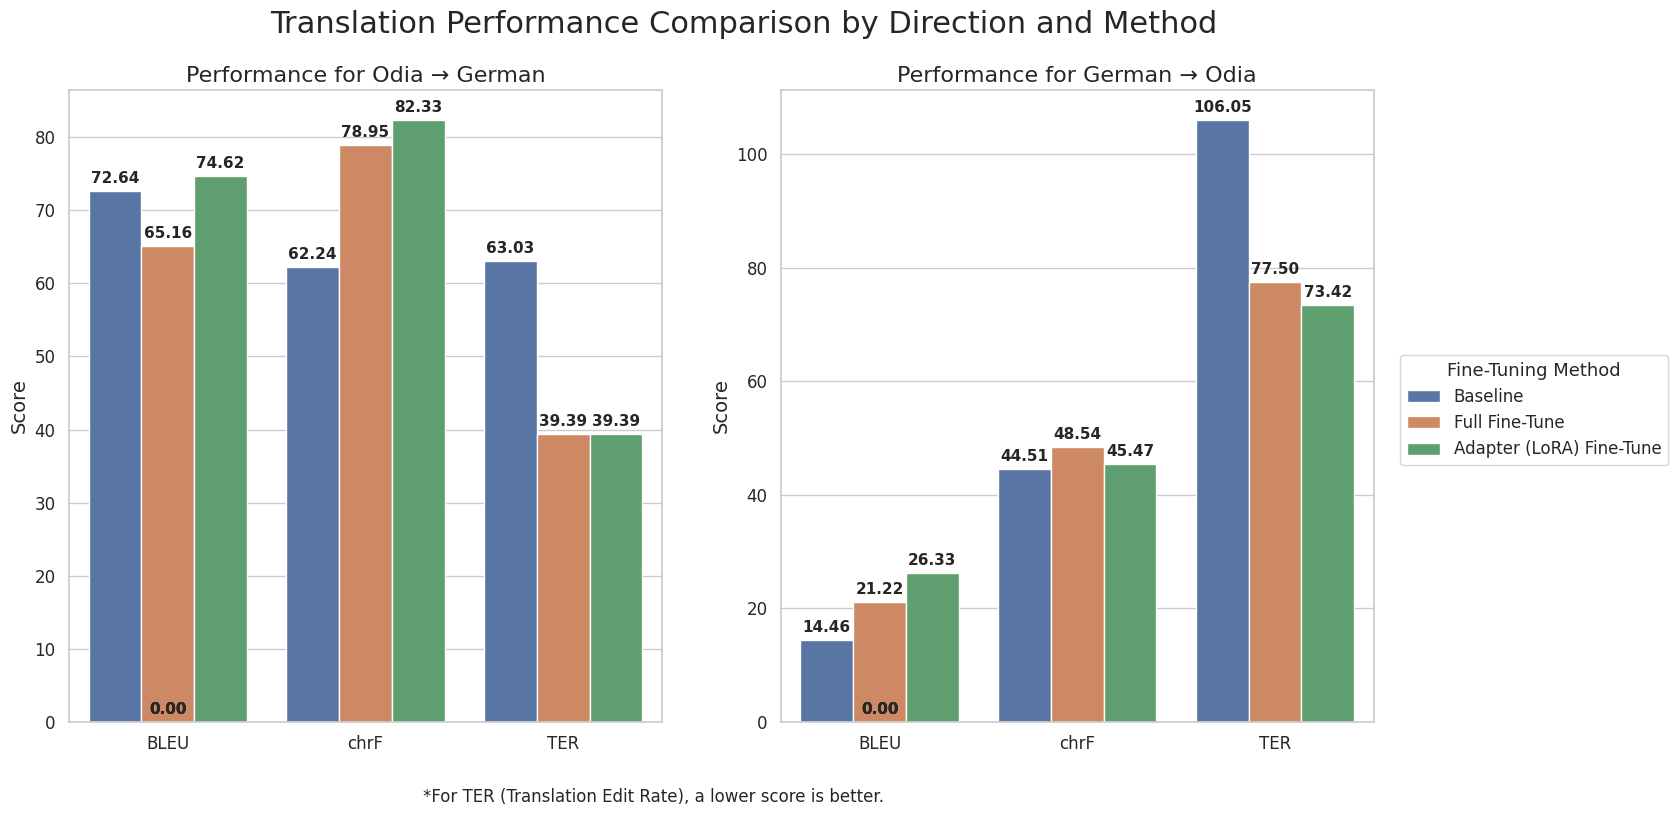

In [ ]:
# --- Generate Final Comparison Visualization ---
print("\n--- Generating Final Performance Visualization ---")

# --- CONSOLIDATE RESULTS DATA ---
plot_data = [
    # Odia -> German Data
    {'Metric': 'BLEU', 'Direction': 'Odia → German', 'Model': 'Baseline', 'Score': baseline_ori_deu_metrics['bleu']},
    {'Metric': 'chrF', 'Direction': 'Odia → German', 'Model': 'Baseline', 'Score': baseline_ori_deu_metrics['chrf']},
    {'Metric': 'TER', 'Direction': 'Odia → German', 'Model': 'Baseline', 'Score': baseline_ori_deu_metrics['ter']},
    {'Metric': 'BLEU', 'Direction': 'Odia → German', 'Model': 'Full Fine-Tune', 'Score': full_finetune_ori_deu_metrics['bleu']},
    {'Metric': 'chrF', 'Direction': 'Odia → German', 'Model': 'Full Fine-Tune', 'Score': full_finetune_ori_deu_metrics['chrf']},
    {'Metric': 'TER', 'Direction': 'Odia → German', 'Model': 'Full Fine-Tune', 'Score': full_finetune_ori_deu_metrics['ter']},
    {'Metric': 'BLEU', 'Direction': 'Odia → German', 'Model': 'Adapter (LoRA) Fine-Tune', 'Score': adapter_ori_deu_metrics['bleu']},
    {'Metric': 'chrF', 'Direction': 'Odia → German', 'Model': 'Adapter (LoRA) Fine-Tune', 'Score': adapter_ori_deu_metrics['chrf']},
    {'Metric': 'TER', 'Direction': 'Odia → German', 'Model': 'Adapter (LoRA) Fine-Tune', 'Score': adapter_ori_deu_metrics['ter']},

    # German -> Odia Data
    {'Metric': 'BLEU', 'Direction': 'German → Odia', 'Model': 'Baseline', 'Score': baseline_deu_ori_metrics['bleu']},
    {'Metric': 'chrF', 'Direction': 'German → Odia', 'Model': 'Baseline', 'Score': baseline_deu_ori_metrics['chrf']},
    {'Metric': 'TER', 'Direction': 'German → Odia', 'Model': 'Baseline', 'Score': baseline_deu_ori_metrics['ter']},
    {'Metric': 'BLEU', 'Direction': 'German → Odia', 'Model': 'Full Fine-Tune', 'Score': full_finetune_deu_ori_metrics['bleu']},
    {'Metric': 'chrF', 'Direction': 'German → Odia', 'Model': 'Fine-Tuned', 'Score': full_finetune_deu_ori_metrics['chrf']},
    {'Metric': 'TER', 'Direction': 'German → Odia', 'Model': 'Full Fine-Tune', 'Score': full_finetune_deu_ori_metrics['ter']},
    {'Metric': 'BLEU', 'Direction': 'German → Odia', 'Model': 'Adapter (LoRA) Fine-Tune', 'Score': adapter_deu_ori_metrics['bleu']},
    {'Metric': 'chrF', 'Direction': 'German → Odia', 'Model': 'Adapter (LoRA) Fine-Tune', 'Score': adapter_deu_ori_metrics['chrf']},
    {'Metric': 'TER', 'Direction': 'German → Odia', 'Model': 'Adapter (LoRA) Fine-Tune', 'Score': adapter_deu_ori_metrics['ter']},
]

# The model name in the results dictionary is 'Fine-Tuned', but for the legend let's rename it
for item in plot_data:
  if item['Model'] == 'Fine-Tuned':
    item['Model'] = 'Full Fine-Tune'

final_plot_df = pd.DataFrame(plot_data)


# --- CREATE THE VISUALIZATION ---

# Set the theme
sns.set_theme(style="whitegrid")

# This ensures "Baseline" is always the same color, "Full Fine-Tune" is always another, etc.
palette_dict = {
    "Baseline": "C0", # Standard blue
    "Full Fine-Tune": "C1", # Standard orange
    "Adapter (LoRA) Fine-Tune": "C2" # Standard green
}

# Create a figure and a set of subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Define the two directions for the loop
directions = ['Odia → German', 'German → Odia']

# Loop through the two axes and directions to create the plots
for i, direction in enumerate(directions):
  ax = axes[i]
  subset_data = final_plot_df[final_plot_df['Direction'] == direction]

  # Create the bar plot on the specific axis, using the consistent palette
  sns.barplot(
      data=subset_data,
      x='Metric',
      y='Score',
      hue='Model',
      palette=palette_dict,
      ax=ax
  )

  ax.set_title(f'Performance for {direction}', fontsize=16)
  ax.set_xlabel('')
  ax.set_ylabel('Score', fontsize=14)
  ax.tick_params(axis='x', labelsize=12)
  ax.tick_params(axis='y', labelsize=12)

  # Add value annotations on top of the bars
  for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
     (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9), textcoords='offset points',
                fontsize=11, fontweight='bold')

# --- FINALIZE THE PLOT ---

# Add a single main title for the entire figure
fig.suptitle('Translation Performance Comparison by Direction and Method', fontsize=22, y=1.0)

# Get handles and labels from one of the plots
handles, labels = axes[0].get_legend_handles_labels()

# Remove the automatically generated legends from the subplots
axes[0].get_legend().remove()
axes[1].get_legend().remove()

# Adjust the subplot layout to make space on the right for the legend
fig.subplots_adjust(right=0.85, top=0.90)

# Create a single, clean legend for the entire figure in the new empty space
fig.legend(
    handles,
    labels,
    loc='center left',
    title='Fine-Tuning Method',
    fontsize=12,
    title_fontsize=13,
    bbox_to_anchor=(0.86, 0.5)
)

# Add a note about TER at the bottom
fig.text(0.45, 0.01, '*For TER (Translation Edit Rate), a lower score is better.', ha='center', fontsize=12)

plt.show()

--- Generating Training and Validation Curves ---


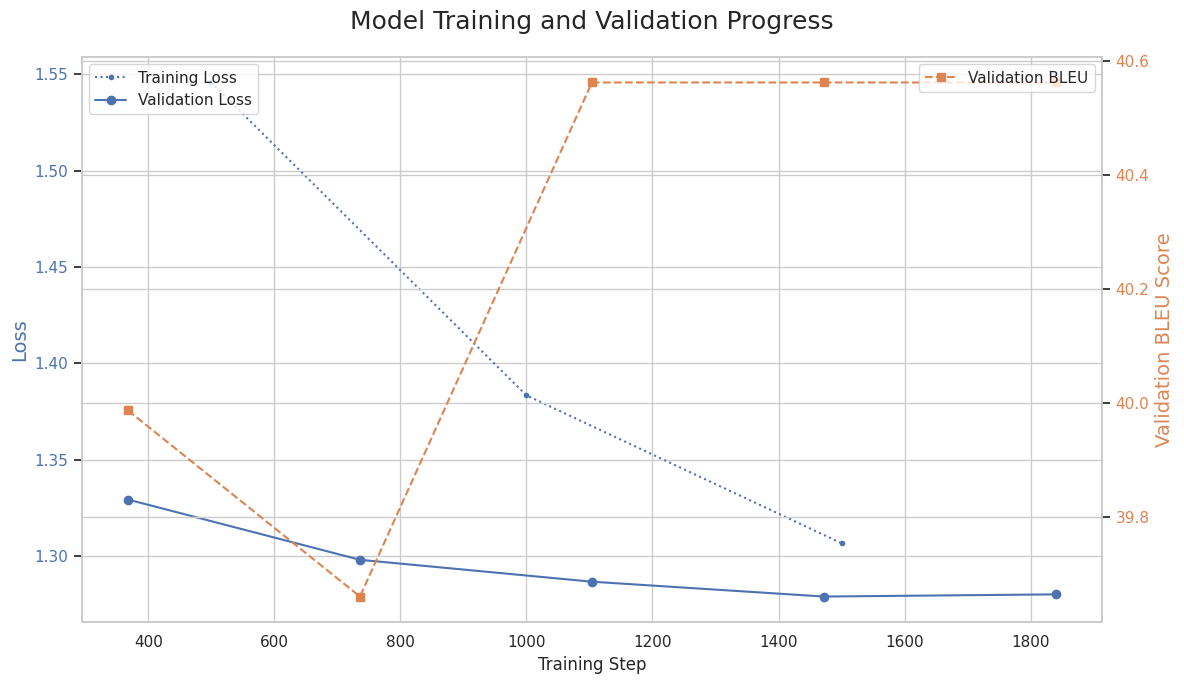

In [ ]:
# --- VISUALIZATION: Training and Validation Progress ---

print("--- Generating Training and Validation Curves ---")

# The trainer object holds the history of the training run
# Extract the logs to a pandas DataFrame for easy plotting
try:
  log_history = trainer.state.log_history
  df_logs = pd.DataFrame(log_history)

  # Separate training and evaluation logs
  df_train = df_logs[df_logs['loss'].notna()].copy()
  df_eval = df_logs[df_logs['eval_loss'].notna()].copy()

  # Create the plot with two y-axes
  sns.set_theme(style="whitegrid")
  fig, ax1 = plt.subplots(figsize=(12, 7))

  # Plot Training and Validation Loss on the primary y-axis (ax1)
  ax1.set_xlabel('Training Step', fontsize=12)
  ax1.set_ylabel('Loss', color='C0', fontsize=14)
  ax1.plot(df_train['step'], df_train['loss'], color='C0', marker='.', linestyle=':', label='Training Loss')
  ax1.plot(df_eval['step'], df_eval['eval_loss'], color='C0', marker='o', linestyle='-', label='Validation Loss')
  ax1.tick_params(axis='y', labelcolor='C0')
  ax1.legend(loc='upper left')

  # Create a second y-axis for the BLEU score
  ax2 = ax1.twinx()
  ax2.set_ylabel('Validation BLEU Score', color='C1', fontsize=14)
  ax2.plot(df_eval['step'], df_eval['eval_bleu'], color='C1', marker='s', linestyle='--', label='Validation BLEU')
  ax2.tick_params(axis='y', labelcolor='C1')
  ax2.legend(loc='upper right')

  plt.title('Model Training and Validation Progress', fontsize=18, pad=20)
  fig.tight_layout()
  plt.show()

except NameError:
  print("\n⛔️ ERROR: The 'trainer' object was not found.")
  print("Please ensure you have run the main Fine-Tuning cell successfully before running this visualization cell.")
except Exception as e:
  print(f"\nAn error occurred: {e}")


--- Generating Score Distribution Visualizations ---

Loading BASELINE model...


Device set to use cuda:0


Translating for Viz:   0%|          | 0/45 [00:00<?, ?it/s]

Device set to use cuda:0


Translating for Viz:   0%|          | 0/48 [00:00<?, ?it/s]


Loading FINE-TUNED model...


Device set to use cuda:0


Translating for Viz:   0%|          | 0/45 [00:00<?, ?it/s]

Device set to use cuda:0


Translating for Viz:   0%|          | 0/48 [00:00<?, ?it/s]

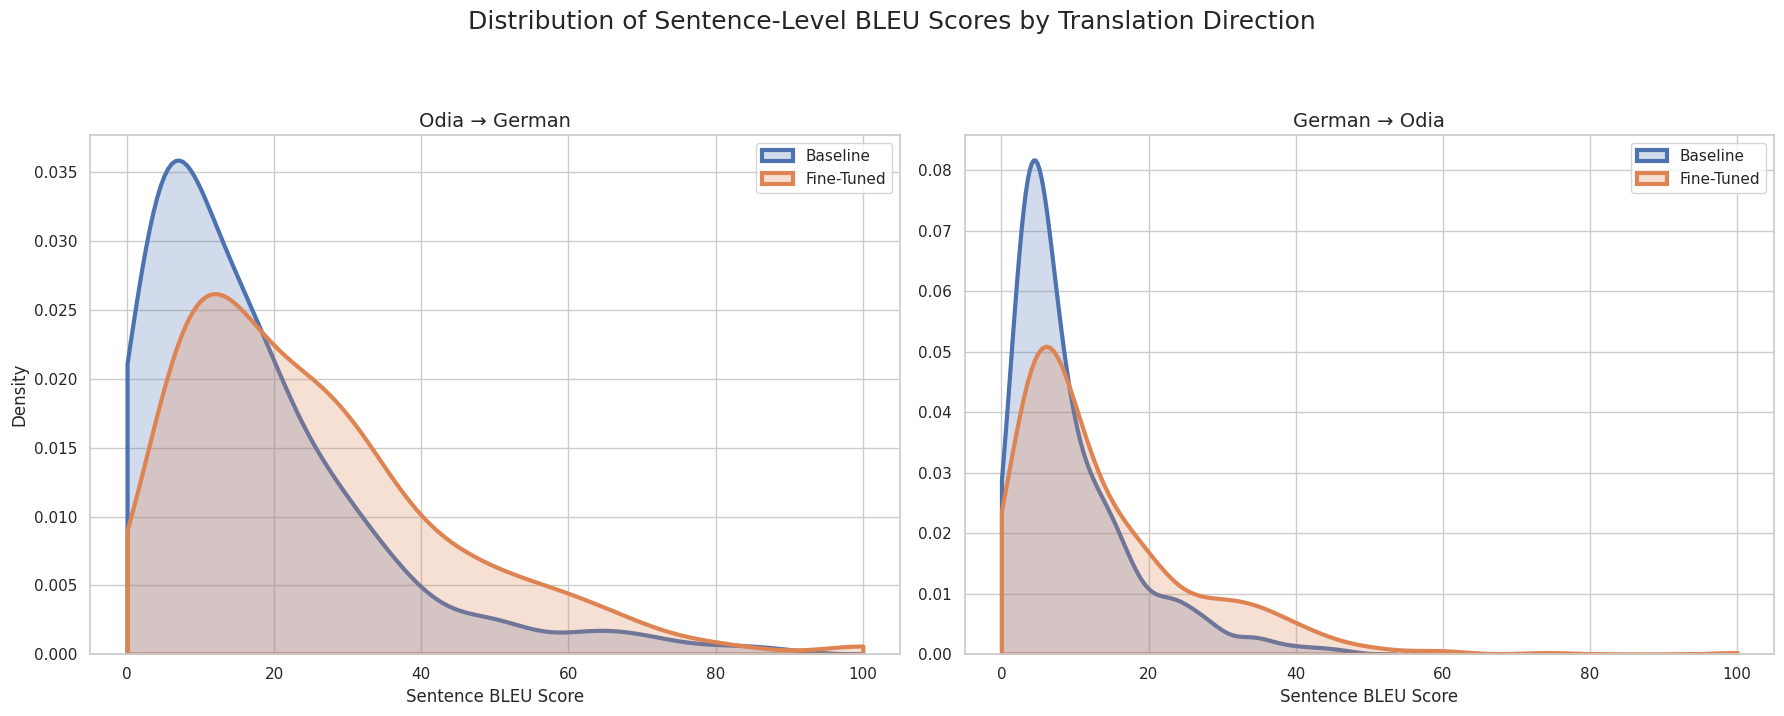

In [ ]:
# --- VISUALIZATION: Score Distribution (KDE Plot) ---
print("\n--- Generating Score Distribution Visualizations ---")

# Helper function to generate predictions for this specific analysis
def generate_predictions_for_viz(model, tokenizer, inputs, src_lang, tgt_lang, batch_size=8):
  """
  Generates translations for a list of input sentences for visualization or analysis.

  This function uses a translation pipeline to generate translations for a list of input sentences,
  processing them in batches to manage memory. It is designed for visualization or analysis tasks,
  such as inspecting model outputs. Progress is displayed using a `tqdm` progress bar.

  Args:
    model (object): The translation model (e.g., a Hugging Face model).
    tokenizer (object): The tokenizer associated with the model.
    inputs (list[str]): A list of input sentences to translate.
    src_lang (str): Source language code (e.g., 'ory_Orya').
    tgt_lang (str): Target language code (e.g., 'deu_Latn').
    batch_size (int, optional): Number of sentences to process per batch. Defaults to 8.

  Returns:
    list[str]: A list of translated sentences.
  """
  translator = pipeline("translation", model=model, tokenizer=tokenizer, src_lang=src_lang, tgt_lang=tgt_lang)
  predictions = []
  for i in tqdm(range(0, len(inputs), batch_size), desc=f"Translating for Viz"):
    batch = inputs[i : i + batch_size]
    preds = translator(batch, max_length=1200)
    predictions.extend([p['translation_text'] for p in preds])
  return predictions

# --- Generate predictions for both models and both directions ---
bnb_config = BitsAndBytesConfig(load_in_8bit=True)

# Baseline Predictions
print("\nLoading BASELINE model...")
base_model_viz = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME, quantization_config=bnb_config, device_map="auto")
baseline_preds_od = generate_predictions_for_viz(base_model_viz, tokenizer, [ex[INPUT_FIELD] for ex in split_datasets['test'] if ex[INPUT_FIELD].startswith(PREFIX_ORI_TO_DEU)], ODIA_LANG_CODE, GERMAN_LANG_CODE)
baseline_preds_do = generate_predictions_for_viz(base_model_viz, tokenizer, [ex[INPUT_FIELD] for ex in split_datasets['test'] if ex[INPUT_FIELD].startswith(PREFIX_DEU_TO_ORI)], GERMAN_LANG_CODE, ODIA_LANG_CODE)
del base_model_viz
torch.cuda.empty_cache()

# Fine-Tuned Predictions
print("\nLoading FINE-TUNED model...")
finetuned_model_viz = AutoModelForSeq2SeqLM.from_pretrained(FINAL_LORA_MODEL_PATH, quantization_config=bnb_config, device_map="auto")
finetuned_preds_od = generate_predictions_for_viz(finetuned_model_viz, tokenizer, [ex[INPUT_FIELD] for ex in split_datasets['test'] if ex[INPUT_FIELD].startswith(PREFIX_ORI_TO_DEU)], ODIA_LANG_CODE, GERMAN_LANG_CODE)
finetuned_preds_do = generate_predictions_for_viz(finetuned_model_viz, tokenizer, [ex[INPUT_FIELD] for ex in split_datasets['test'] if ex[INPUT_FIELD].startswith(PREFIX_DEU_TO_ORI)], GERMAN_LANG_CODE, ODIA_LANG_CODE)
del finetuned_model_viz
torch.cuda.empty_cache()

# --- Calculate sentence-level BLEU scores ---
sbleu = sacrebleu.BLEU(effective_order=True)

# For Odia -> German
refs_od = [[ex[TARGET_FIELD]] for ex in split_datasets['test'] if ex[INPUT_FIELD].startswith(PREFIX_ORI_TO_DEU)]
baseline_scores_od = [sbleu.sentence_score(pred, ref).score for pred, ref in zip(baseline_preds_od, refs_od)]
finetuned_scores_od = [sbleu.sentence_score(pred, ref).score for pred, ref in zip(finetuned_preds_od, refs_od)]
df_dist_od = pd.DataFrame({'Baseline': baseline_scores_od, 'Fine-Tuned': finetuned_scores_od})

# For German -> Odia
refs_do = [[ex[TARGET_FIELD]] for ex in split_datasets['test'] if ex[INPUT_FIELD].startswith(PREFIX_DEU_TO_ORI)]
baseline_scores_do = [sbleu.sentence_score(pred, ref).score for pred, ref in zip(baseline_preds_do, refs_do)]
finetuned_scores_do = [sbleu.sentence_score(pred, ref).score for pred, ref in zip(finetuned_preds_do, refs_do)]
df_dist_do = pd.DataFrame({'Baseline': baseline_scores_do, 'Fine-Tuned': finetuned_scores_do})

# --- Create the plots ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
sns.set_theme(style="whitegrid")
fig.suptitle('Distribution of Sentence-Level BLEU Scores by Translation Direction', fontsize=18, y=1.02)

# Plot 1: Odia -> German
sns.kdeplot(data=df_dist_od, x='Baseline', fill=True, label='Baseline', clip=(0, 100), lw=3, ax=axes[0], color='C0')
sns.kdeplot(data=df_dist_od, x='Fine-Tuned', fill=True, label='Fine-Tuned', clip=(0, 100), lw=3, ax=axes[0], color='C1')
axes[0].set_title('Odia → German', fontsize=14)
axes[0].set_xlabel('Sentence BLEU Score', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].legend()

# Plot 2: German -> Odia
sns.kdeplot(data=df_dist_do, x='Baseline', fill=True, label='Baseline', clip=(0, 100), lw=3, ax=axes[1], color='C0')
sns.kdeplot(data=df_dist_do, x='Fine-Tuned', fill=True, label='Fine-Tuned', clip=(0, 100), lw=3, ax=axes[1], color='C1')
axes[1].set_title('German → Odia', fontsize=14)
axes[1].set_xlabel('Sentence BLEU Score', fontsize=12)
axes[1].set_ylabel('')
axes[1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()